In [15]:
# Install packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from scipy.sparse import hstack
from sklearn.metrics import classification_report, confusion_matrix
import sklearn
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_extraction, feature_selection, model_selection

In [16]:
# Load data
df = pd.read_csv("mbti_preprocessed_features.csv", index_col= 0)

In [17]:
def create_train_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42069)
    return X_train, X_test, Y_train, Y_test

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [19]:
feature = ['avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations']

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

 Introverted       0.84      0.81      0.82      2002
 Extroverted       0.43      0.47      0.45       601

    accuracy                           0.73      2603
   macro avg       0.63      0.64      0.64      2603
weighted avg       0.74      0.73      0.74      2603

0.7322320399538993


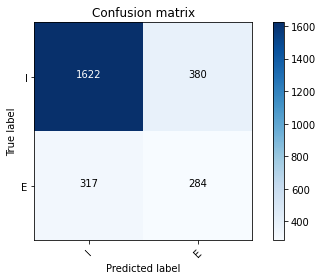

In [12]:
# Binary + Features - Balanced
# Extro - Intro

# Determine X and Y
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 4].values #Extro-Intro

# Create splits
X_train_EI, X_test_EI, Y_train_EI, Y_test_EI = create_train_test_split(X, Y)

# Balance data
sampler = RandomOverSampler()
X_train_balanced_EI, Y_train_balanced_EI = sampler.fit_resample(X_train_EI, Y_train_EI)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_balanced_EI["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_balanced_EI):
    chi2, p = feature_selection.chi2(X_training, Y_train_balanced_EI == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect = vectorizer.transform(corpus)
df_tfidfvect = hstack([df_tfidfvect, X_train_balanced_EI[feature]])
tfidf_tokens = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = df_tfidfvect.toarray(),columns = tfidf_tokens + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect[feature] = scaler.fit_transform(df_tfidfvect[feature])

corpus = X_test_EI["preprocessed_posts"].values.astype(str)
df_tfidfvect_test = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test = hstack([df_tfidfvect_test, X_test_EI[feature]])
tfidf_tokens_test = vectorizer.get_feature_names()
df_tfidfvect_test = pd.DataFrame(data = df_tfidfvect_test.toarray(),columns = tfidf_tokens_test + feature)

# Normalise Features
df_tfidfvect_test[feature] = scaler.transform(df_tfidfvect_test[feature])

# Train Model
dt = DecisionTreeClassifier()
dt = dt.fit(df_tfidfvect, Y_train_balanced_EI)

# Prediction & Evaluation
prediction_EI = dt.predict(df_tfidfvect_test)

types = ['Introverted', 'Extroverted']

print("Classification Report:")
print(classification_report(Y_test_EI, prediction_EI, target_names=types))
print(sklearn.metrics.f1_score(Y_test_EI, prediction_EI, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_EI, prediction_EI)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['I','E'])

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

     Sensing       0.40      0.42      0.41       342
   Intuition       0.91      0.90      0.91      2261

    accuracy                           0.84      2603
   macro avg       0.66      0.66      0.66      2603
weighted avg       0.85      0.84      0.84      2603

0.8417210910487899


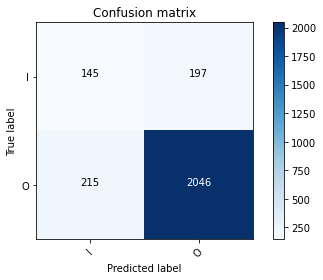

In [22]:
# Binary Sensing-Intuition - Balanced

# Determine X and Y 
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 5].values #intu-obs

# Create splits
X_train_IO, X_test_IO, Y_train_IO, Y_test_IO = create_train_test_split(X, Y)

# Balance data
sampler = RandomOverSampler()
X_train_balanced_IO, Y_train_balanced_IO = sampler.fit_resample(X_train_IO, Y_train_IO)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_balanced_IO["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_balanced_IO):
    chi2, p = feature_selection.chi2(X_training, Y_train_balanced_IO == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect = vectorizer.transform(corpus)
df_tfidfvect = hstack([df_tfidfvect, X_train_balanced_IO[feature]])
tfidf_tokens = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = df_tfidfvect.toarray(),columns = tfidf_tokens + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect[feature] = scaler.fit_transform(df_tfidfvect[feature])

corpus = X_test_IO["preprocessed_posts"].values.astype(str)
df_tfidfvect_test = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test = hstack([df_tfidfvect_test, X_test_IO[feature]])
tfidf_tokens_test = vectorizer.get_feature_names()
df_tfidfvect_test = pd.DataFrame(data = df_tfidfvect_test.toarray(),columns = tfidf_tokens_test + feature)

# Normalise Features
df_tfidfvect_test[feature] = scaler.transform(df_tfidfvect_test[feature])

# Train Model
dt = DecisionTreeClassifier()
dt = dt.fit(df_tfidfvect, Y_train_balanced_IO)

# Prediction & Evaluation
prediction_IO = dt.predict(df_tfidfvect_test)

types = ['Sensing', 'Intuition']

print("Classification Report:")
print(classification_report(Y_test_IO, prediction_IO, target_names=types))
print(sklearn.metrics.f1_score(Y_test_IO, prediction_IO, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_IO, prediction_IO)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['I','O'])

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

    Thinking       0.66      0.65      0.65      1199
     Feeling       0.70      0.71      0.71      1404

    accuracy                           0.68      2603
   macro avg       0.68      0.68      0.68      2603
weighted avg       0.68      0.68      0.68      2603

0.6815213215520554


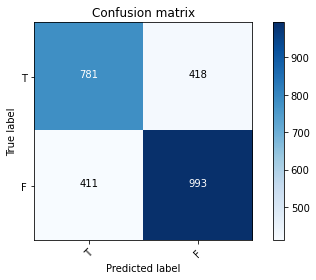

In [23]:
# Binary Thinking-Feeling - Balanced

# Determine X and Y 
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 6].values # think - feel

# Create splits
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = create_train_test_split(X, Y)

# Balance data
sampler = RandomOverSampler()
X_train_balanced_TF, Y_train_balanced_TF = sampler.fit_resample(X_train_TF, Y_train_TF)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_balanced_TF["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_balanced_TF):
    chi2, p = feature_selection.chi2(X_training, Y_train_balanced_TF == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect = vectorizer.transform(corpus)
df_tfidfvect = hstack([df_tfidfvect, X_train_balanced_TF[feature]])
tfidf_tokens = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = df_tfidfvect.toarray(),columns = tfidf_tokens + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect[feature] = scaler.fit_transform(df_tfidfvect[feature])

corpus = X_test_TF["preprocessed_posts"].values.astype(str)
df_tfidfvect_test = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test = hstack([df_tfidfvect_test, X_test_TF[feature]])
tfidf_tokens_test = vectorizer.get_feature_names()
df_tfidfvect_test = pd.DataFrame(data = df_tfidfvect_test.toarray(),columns = tfidf_tokens_test + feature)

# Normalise Features
df_tfidfvect_test[feature] = scaler.transform(df_tfidfvect_test[feature])

# Train Model
dt = DecisionTreeClassifier()
dt = dt.fit(df_tfidfvect, Y_train_balanced_TF)

# Prediction & Evaluation
prediction_TF = dt.predict(df_tfidfvect_test)

types = ['Thinking', 'Feeling']

print("Classification Report:")
print(classification_report(Y_test_TF, prediction_TF, target_names=types))
print(sklearn.metrics.f1_score(Y_test_TF, prediction_TF, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_TF, prediction_TF)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['T','F'])

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Classification Report:
              precision    recall  f1-score   support

     Judging       0.61      0.58      0.60      1071
  Perceiving       0.72      0.74      0.73      1532

    accuracy                           0.68      2603
   macro avg       0.66      0.66      0.66      2603
weighted avg       0.67      0.68      0.67      2603

0.676142912024587


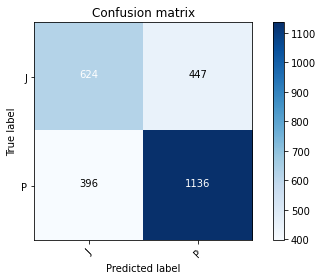

In [24]:
# Binary Judging-Perceiving - Balanced

# Determine X and Y 
X = df[['preprocessed_posts', 'avg_word_count', 'avg_exclam_count', 'avg_fullstop_count', 'avg_count_of_hello', 'avg_count_of_hi', 'avg_count_of_extroverted_bigrams', 'avg_count_of_extroverted_stylistic_impressions',	'avg_count_of_interoverted_quantifiers',	'avg_count_of_introverted_first_person_singular_pronoun',	'avg_count_of_introverted_negations' ]] #Preprocessed_posts #Preprocessed_Posts + Features
Y = df.iloc[:, 7].values # think - feel

# Create splits
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = create_train_test_split(X, Y)

# Balance data
sampler = RandomOverSampler()
X_train_balanced_JP, Y_train_balanced_JP = sampler.fit_resample(X_train_JP, Y_train_JP)

## TF-IDF
vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.3, max_features=10000)

##Extract Vocabulary
corpus = X_train_balanced_JP["preprocessed_posts"].values.astype(str)
vectorizer.fit(corpus)
X_training = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_
# print("Training vocabulary size before dimension reduction: " + str(len(dic_vocabulary)))

# Feature Selection

##Reduce Dimensionality for sparse data with Chi-Quadrat
X_names = vectorizer.get_feature_names_out()
p_value_limit = 0.95
features = pd.DataFrame()
# print("Top Features for Each Class:")
for cat in np.unique(Y_train_balanced_JP):
    chi2, p = feature_selection.chi2(X_training, Y_train_balanced_JP == cat)
    features = features.append(pd.DataFrame(
        {"feature": X_names, "score": 1 - p, "y": cat}))
    features = features.sort_values(["y", "score"], ascending=[True, False])
    features = features[features["score"] > p_value_limit]
X_names = features["feature"].unique().tolist()

##Re-Fit vectorizer on corpus with new set of words and create new sparse matrix
vectorizer = TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)

df_tfidfvect = vectorizer.transform(corpus)
df_tfidfvect = hstack([df_tfidfvect, X_train_balanced_JP[feature]])
tfidf_tokens = vectorizer.get_feature_names()
df_tfidfvect = pd.DataFrame(data = df_tfidfvect.toarray(),columns = tfidf_tokens + feature)

# Normalise Features
scaler = MinMaxScaler()
df_tfidfvect[feature] = scaler.fit_transform(df_tfidfvect[feature])

corpus = X_test_TF["preprocessed_posts"].values.astype(str)
df_tfidfvect_test = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

df_tfidfvect_test = hstack([df_tfidfvect_test, X_test_JP[feature]])
tfidf_tokens_test = vectorizer.get_feature_names()
df_tfidfvect_test = pd.DataFrame(data = df_tfidfvect_test.toarray(),columns = tfidf_tokens_test + feature)

# Normalise Features
df_tfidfvect_test[feature] = scaler.transform(df_tfidfvect_test[feature])

# Train Model
dt = DecisionTreeClassifier()
dt = dt.fit(df_tfidfvect, Y_train_balanced_JP)

# Prediction & Evaluation
prediction_JP = dt.predict(df_tfidfvect_test)

types = ['Judging', 'Perceiving']

print("Classification Report:")
print(classification_report(Y_test_JP, prediction_JP, target_names=types))
print(sklearn.metrics.f1_score(Y_test_JP, prediction_JP, average ='micro'))

# Confusion Matrix
cnf = confusion_matrix(Y_test_JP, prediction_JP)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = ['J','P'])

In [25]:
# Combine the 4 Binary Models
df1 = df[['encodedType', 'extro_intro', 'intu_obs', 'feel_think', 'prosp_judg']].drop_duplicates().reset_index(drop=True)

Y_test_df = pd.DataFrame(np.transpose([Y_test_EI, Y_test_JP, Y_test_IO, Y_test_TF]), 
                         columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
Y_test_df = Y_test_df.merge(df1, how = 'left', on = Y_test_df.columns.tolist())

predict_df = pd.DataFrame(np.transpose([prediction_EI, prediction_JP, prediction_IO, prediction_TF]), 
                         columns =['extro_intro', 'intu_obs', 'feel_think', 'prosp_judg'])
predict_df = predict_df.merge(df1, how = 'left', on = predict_df.columns.tolist())

print("Classification Report:")
print(classification_report(Y_test_df['encodedType'].values, predict_df['encodedType'].values))

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.29      0.31       196
           1       0.28      0.23      0.25       212
           2       0.11      0.11      0.11        28
           3       0.00      0.00      0.00        14
           4       0.16      0.24      0.20        74
           5       0.07      0.15      0.09        55
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00        11
           8       0.34      0.40      0.37       378
           9       0.44      0.46      0.45       545
          10       0.21      0.17      0.19        86
          11       0.23      0.30      0.26        73
          12       0.37      0.28      0.32       365
          13       0.41      0.34      0.37       436
          14       0.18      0.15      0.16        61
          15       0.17      0.16      0.16        58

    accuracy                           0.32      2603
   

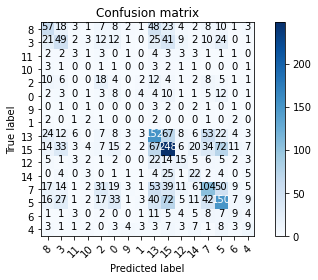

In [26]:
# plot confusion amtrix
cnf = confusion_matrix(Y_test_df['encodedType'].values, predict_df['encodedType'].values)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = df1['encodedType'])